In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [39]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True


# feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # F-value between label/feature for regression tasks.

# model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgbm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle


from final.random_sampling.even_sample_brand import stratified_sampling_by_brand
from final.random_sampling.even_sample_category import stratified_sampling_by_category
from final.random_sampling.even_sample_by_price_range import stratified_sampling_by_price
from final.feature_extraction.text_vectorization import encode_categories,encode_string_column

from final.hyperparameter_tuning.search_cv import CV_Model
from final.helper.save_data import save_np_file

from final.model_evaluation.error_function import mape
from final.model_evaluation.visualizations import plot_prediction_price
from final.model_evaluation.regression_cvs import find_train_best_model

# Get sample df

In [3]:
df = pd.read_csv("../../data/clean_data_with_text_features.csv")
df = stratified_sampling_by_brand(df, file_dir="data",number_samples = 10000,
                                               replace = False, save_sample_df = False)

vera wang              6
cole haan              6
lola                   6
american eagle         6
crest                  6
                      ..
southpole              5
jafra                  5
creativity for kids    5
david s bridal         5
blinc                  5
Name: brand_name, Length: 1678, dtype: int64


In [4]:
df.shape

(10000, 46)

In [5]:
df.head(5)

,,train_id,item_condition_id,brand_name,price,shipping,c1,c2,c3,clean_name,clean_description,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
apple bottoms,29180,29210,1,apple bottoms,26.0,0,woman,shoe,flat,toms shoes new,toms shoes size 8 new,...,0.324324,0.352941,0.923077,0.392857,0.000000,0.068966,0.052632,0.000000,0.005747,0.004734
cherokee,40549,40593,3,cherokee,15.0,1,woman,pant,cargo,cherokee cargo scrub pants,gently worn navy blue size xl elastic waist sm...,...,0.189189,0.235294,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.005747,0.003550
ivanka trump,1418080,1419473,3,ivanka trump,39.0,0,woman,shoe,pump,ivanka trump multi color pony heels s 9,very comfortable and like new only wore once t...,...,0.297297,0.323529,0.916667,0.357143,0.111111,0.000000,0.000000,0.057377,0.005747,0.002367
silver jeans co,415555,415916,3,silver jeans co,26.0,0,woman,jean,boot cut,silver jeans euc,silver jeans in excellent shape not sure on si...,...,0.378378,0.382353,0.866667,0.285714,0.000000,0.000000,0.000000,0.065574,0.003831,0.003550
laura geller,373452,373774,3,laura geller,19.0,1,beauty,makeup,face,laura geller gelato swirl illuminator,authentic laura geller gelato swirl highlight ...,...,0.297297,0.323529,0.916667,0.357143,0.000000,0.000000,0.000000,0.008197,0.003831,0.001183


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, ('apple bottoms', 29180) to ('attention', 57799)
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   train_id                          10000 non-null  int64  
 1   item_condition_id                 10000 non-null  int64  
 2   brand_name                        10000 non-null  object 
 3   price                             10000 non-null  float64
 4   shipping                          10000 non-null  int64  
 5   c1                                10000 non-null  object 
 6   c2                                10000 non-null  object 
 7   c3                                10000 non-null  object 
 8   clean_name                        10000 non-null  object 
 9   clean_description                 10000 non-null  object 
 10  clean_nameWordCount               10000 non-null  float64
 11  clean_nameLength             

# Train Test Split

In [7]:
Y = np.log1p(df['price'])
df.drop(['price'], axis=1, inplace=True)
df.head(2)

,,train_id,item_condition_id,brand_name,shipping,c1,c2,c3,clean_name,clean_description,clean_nameWordCount,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
apple bottoms,29180,29210,1,apple bottoms,0,woman,shoe,flat,toms shoes new,toms shoes size 8 new,0.1250,...,0.324324,0.352941,0.923077,0.392857,0.0,0.068966,0.052632,0.0,0.005747,0.004734
cherokee,40549,40593,3,cherokee,1,woman,pant,cargo,cherokee cargo scrub pants,gently worn navy blue size xl elastic waist sm...,0.1875,...,0.189189,0.235294,1.000000,0.500000,0.0,0.000000,0.000000,0.0,0.005747,0.003550


In [8]:
train_df, test_df , y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=12342)
print('Train size: %s, Test size: %s'%(train_df.shape, test_df.shape))

Train size: (8000, 45), Test size: (2000, 45)


# Vectorization

In [9]:
train_cat_features, test_cat_features, train_cat_features_name = encode_categories(train_df, test_df,
                                                                columns = ['c1','c2','c3','brand_name'], 
                                                                min_df = 10, print_progress=True)

Size of vectorization features of c1 is 12
Size of vectorization features of c2 is 100
Size of vectorization features of c3 is 267
Size of vectorization features of brand_name is 219
Shape of train vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (8000, 598)
Shape of test vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (2000, 598)


In [10]:
train_str_features, test_str_features, train_str_features_name = encode_string_column(train_df, test_df,
                                                                   columns=['clean_name', 'clean_description'],
                                                                   min_df=10, max_features=15000, 
                                                                   print_progress=True)

Size of vectorization features of clean_name is 655
Size of vectorization features of clean_description is 4014
Shape of train vectorization features of ['clean_name', 'clean_description'] is (8000, 4669)
Shape of test vectorization features of ['clean_name', 'clean_description'] is (2000, 4669)


# Combine all features

In [11]:
other_columns = list(train_df.select_dtypes([np.number]).columns)
other_columns.remove('train_id')
other_columns

['item_condition_id',
 'shipping',
 'clean_nameWordCount',
 'clean_nameLength',
 'clean_nameLowerCount',
 'clean_nameLowerRatio',
 'clean_nameAvgWordLen',
 'clean_descriptionWordCount',
 'clean_descriptionLength',
 'clean_descriptionLowerCount',
 'clean_descriptionLowerRatio',
 'clean_descriptionAvgWordLen',
 'c1WordCount',
 'c1Length',
 'c1LowerCount',
 'c1LowerRatio',
 'c1AvgWordLen',
 'c2WordCount',
 'c2Length',
 'c2LowerCount',
 'c2LowerRatio',
 'c2AvgWordLen',
 'c3WordCount',
 'c3Length',
 'c3LowerCount',
 'c3LowerRatio',
 'c3AvgWordLen',
 'brand_nameWordCount',
 'brand_nameLength',
 'brand_nameLowerCount',
 'brand_nameLowerRatio',
 'brand_nameAvgWordLen',
 'nameStopWordCount',
 'namePunctuationCount',
 'nameSpecialCount',
 'item_descriptionStopWordCount',
 'item_descriptionPunctuationCount',
 'item_descriptionSpecialCount']

In [12]:
train_other_features = train_df[other_columns].values
test_other_features = test_df[other_columns].values
print('Train other features size: %s, Test other features size: %s'%(train_other_features.shape, 
                                                                     test_other_features.shape))

Train other features size: (8000, 38), Test other features size: (2000, 38)


In [13]:
all_train = np.hstack((train_cat_features, train_str_features, train_other_features))
all_test = np.hstack((test_cat_features, test_str_features, test_other_features))
print('Train features size: %s, Test features size: %s'%(all_train.shape, 
                                                         all_test.shape))

Train features size: (8000, 5305), Test features size: (2000, 5305)


In [14]:
all_feature_name = np.array(train_cat_features_name[0] + train_cat_features_name[1] \
                    +train_cat_features_name[2] + train_cat_features_name[3] \
                    +train_str_features_name[0]+train_str_features_name[1] \
                    + other_columns)

In [15]:
len(all_feature_name)

5305

# Feature Selection

# RFE

In [16]:
estimator = Ridge(alpha=1)
selector = RFE(estimator, step=0.05, n_features_to_select = 500) # everytime drop 5% features
selector = selector.fit(all_train, y_train)

In [17]:
selector.support_

array([False, False, False, ...,  True, False, False])

In [18]:
all_feature_name[selector.ranking_][:10]

array(['missing', 'athletic', 'home', 'men', 'missing', '24', 'and',
       'appliances', '2t', '2t'], dtype='<U32')

In [19]:
save_np_file(dir = "../../data", 
             filename="rfe_select_feature_name_brand_sample_10000", 
             data=all_feature_name[selector.ranking_])

In [20]:
selector.support_.shape

(5305,)

In [21]:
all_train.shape

(8000, 5305)

In [22]:
x_rfe_select_train = all_train[:,selector.support_]
x_rfe_select_train.shape

(8000, 500)

In [23]:
x_rfe_select_test = all_test[:,selector.support_]
x_rfe_select_test.shape

(2000, 500)

# Hyperparameter Tuning

In [24]:
SearchCV = CV_Model(GridSearch=False)

## KNN

In [25]:
classifier = KNeighborsRegressor()
parameters = {'n_neighbors': [5, 10, 50, 100], 'weights': ['uniform', 'distance']}

### Train with select k best features

In [26]:
x_rfe_select_train.shape

(8000, 500)

Best Estimator KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')
Best Parameters:  {'weights': 'distance', 'n_neighbors': 10}
Best Score:  -0.46760968133747544
Result of using Feature from select k best model
--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference:  2.3948815881574084
With Original Price 14.00, Predict Price 47.53: 
Min Percentage Difference:  0.0
With Original Price 17.00, Predict Price 17.00: 
RMSLE is  0.031238148331341174
R^2  is  0.9982776910759407
Mean Absolute Percentage Error is  0.1843478012927487

Test Result ----------
Max Percentage Difference:  6.87254056004804
With Original Price 8.00, Predict Price 62.98: 
Min Percentage Difference:  0.0
With Original Price 28.00, Predict Price 28.00: 
RMSLE is  0.7188103000801146
R^2 is  0.14282839500482536
Mean Absolute Percent

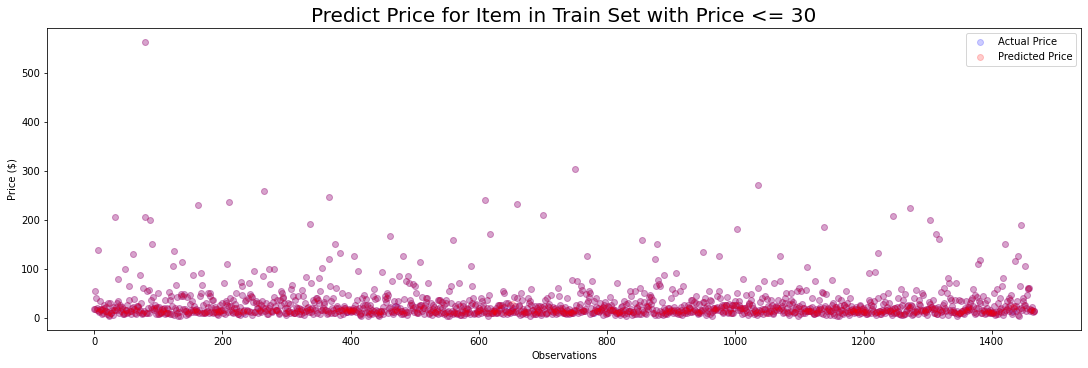

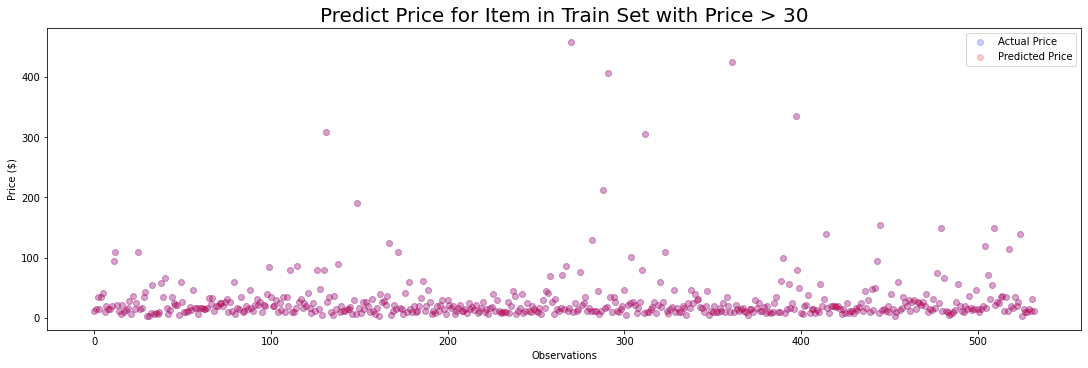

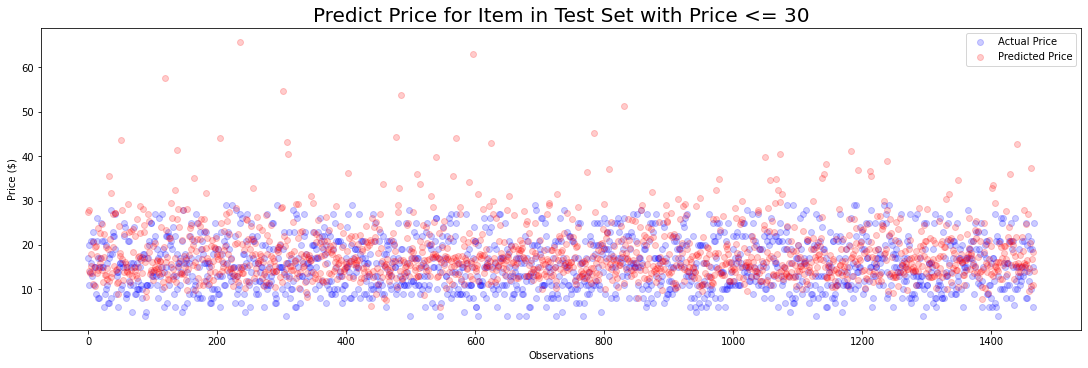

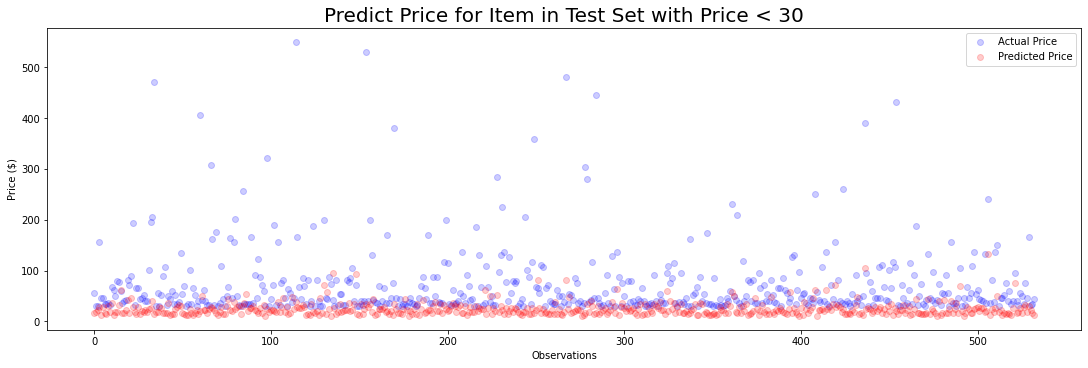

In [27]:
find_train_best_model(classifier, parameters, x_rfe_select_train, y_train, 
                      x_rfe_select_test, y_test, data_name="Feature from select k best model", price_split=30)

## Ridge

### Train with select k best features

In [28]:
classifier = Ridge()
parameters = {'alpha': [1, 2, 3, 3.5, 4, 4.5, 5]}

Best Estimator Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
Best Parameters:  {'alpha': 1}
Best Score:  -0.35507091141333375
Result of using Feature from select k best model
--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference:  12.130195413634128
With Original Price 3.00, Predict Price 39.39: 
Min Percentage Difference:  3.662060720088789e-06
With Original Price 20.00, Predict Price 20.00: 
RMSLE is  0.5594639722995596
R^2  is  0.4475604848073935
Mean Absolute Percentage Error is  49.69690772809777

Test Result ----------
Max Percentage Difference:  7.107302908313605
With Original Price 9.00, Predict Price 72.97: 
Min Percentage Difference:  0.0007652041943504884
With Original Price 15.00, Predict Price 14.99: 
RMSLE is  0.6707860348427639
R^2 is  0.2535388362447317
Mean Absolute Percentage Error is  54.278455626431985
--------------------

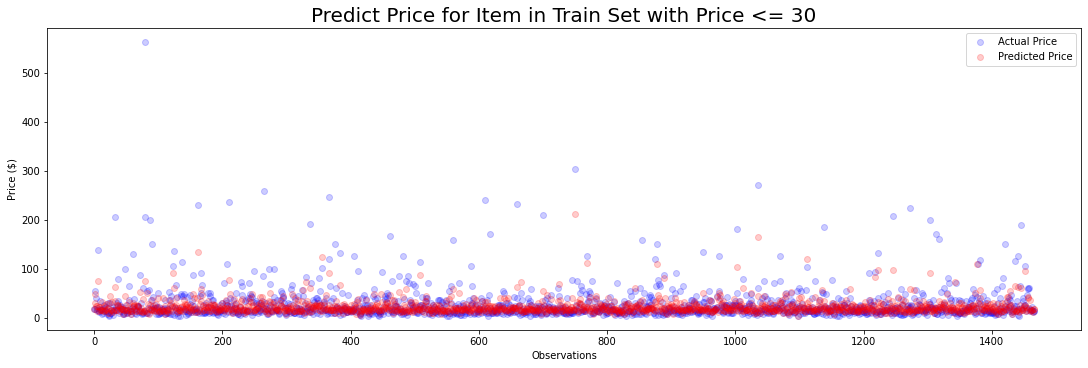

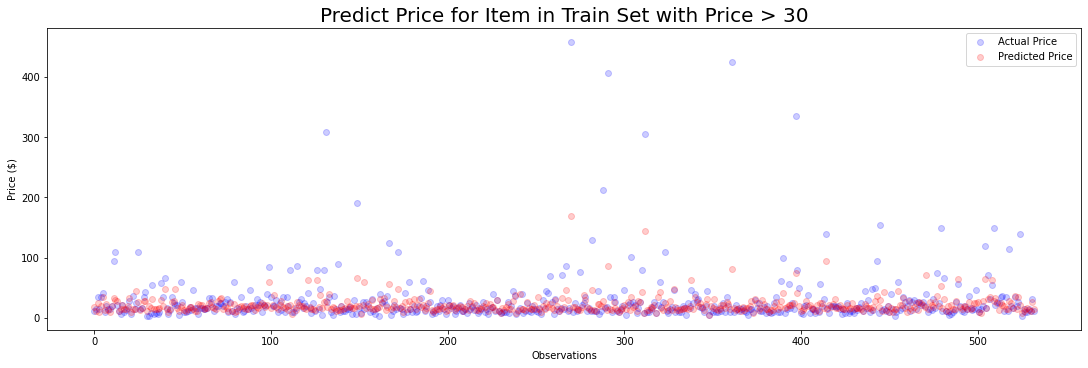

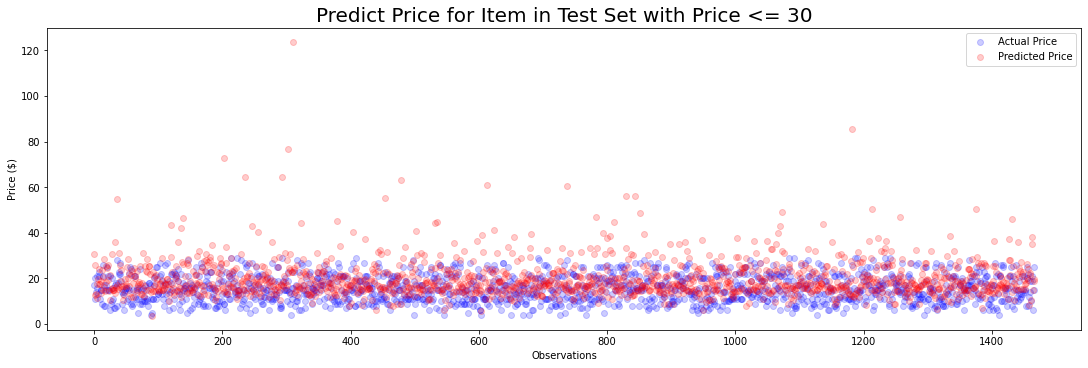

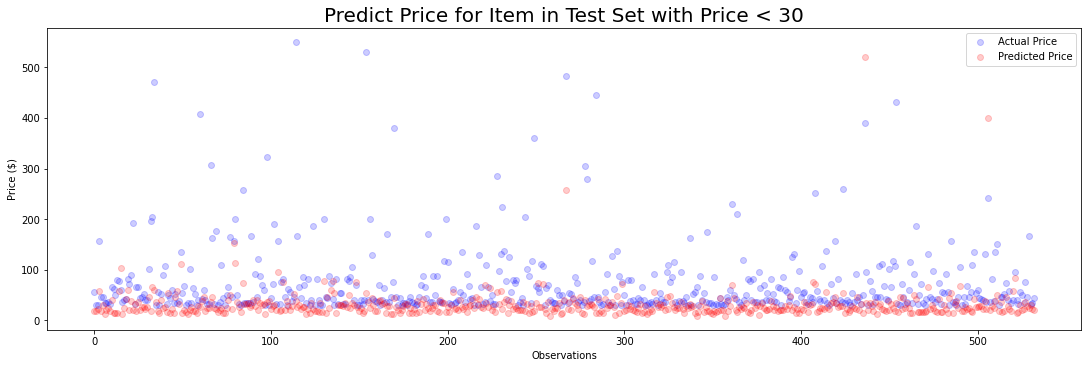

In [29]:
find_train_best_model(classifier, parameters, x_rfe_select_train, y_train, 
                      x_rfe_select_test, y_test, data_name="Feature from select k best model", price_split=30)

## RandomForestRegressor

### Train with select k best features

In [30]:
classifier = RandomForestRegressor()
parameters = {'n_estimators': [10, 50, 100, 500], 'max_features': [50, 100, 500]}

Best Estimator RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=100, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Best Parameters:  {'n_estimators': 500, 'max_features': 100}
Best Score:  -0.42602155837218636
Result of using Feature from select k best model
--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference:  1.912531908960261
With Original Price 4.00, Predict Price 11.65: 
Min Percentage Difference:  6.62088421911733e-05
With Original Price 15.00, Predict Price 15.00: 
RMSLE is  0.2400389354846226
R^2  is  0.898304000157798
Mean Absol

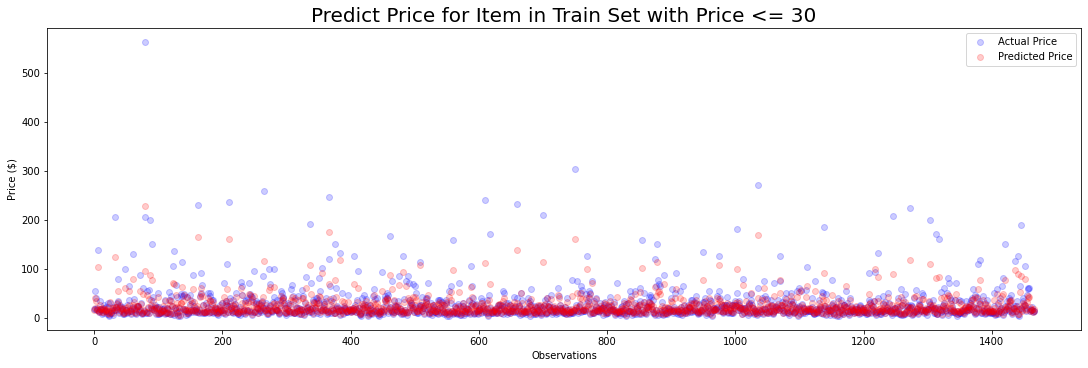

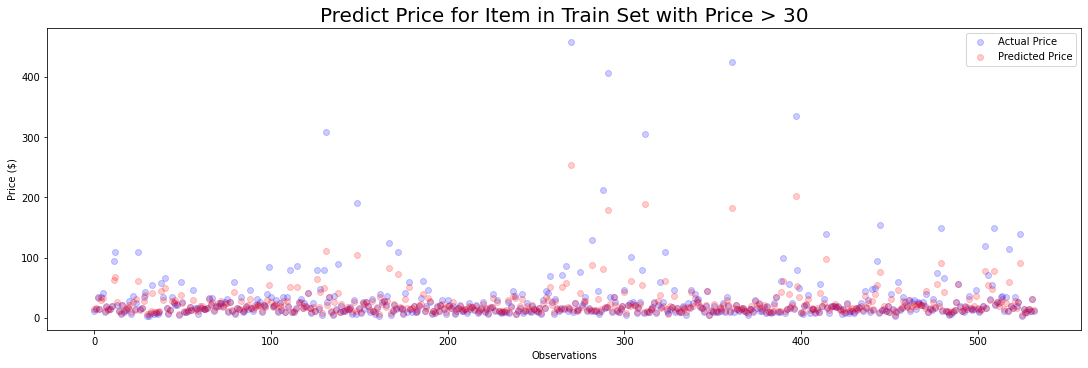

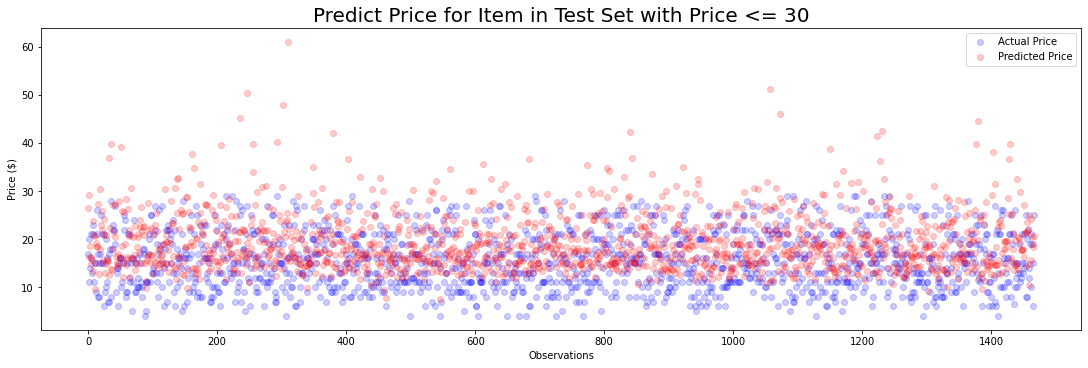

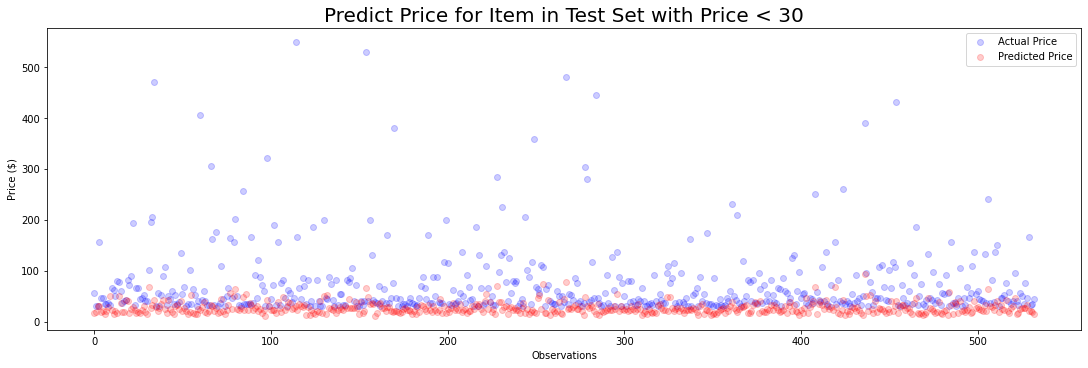

In [31]:
find_train_best_model(classifier, parameters, x_rfe_select_train, y_train, 
                      x_rfe_select_test, y_test, data_name="Feature from select k best model", price_split=30)

## Light GBM Regressor

In [42]:
classifier = lgbm.LGBMRegressor()
parameters = {'max_depth': [2,4,6,8,10],
              'learning_rate': [0.0001,0.001, 0.01, 0.1, 0.2],
              'n_estimators': [100, 200, 500, 1000,1500]
             }

Best Estimator LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Best Parameters:  {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
Best Score:  -0.46525873736240286
Result of using Feature from select k best model
--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference:  8.534582827918875
With Original Price 3.00, Predict Price 28.60: 
Min Percentage Difference:  9.552553756009275e-07
With Original Price 20.00, Predict Price 20.00: 
RMSLE is  0.6376132876890059
R^2  is  0.28244498441344845
Mean Absolute Percentage Error i

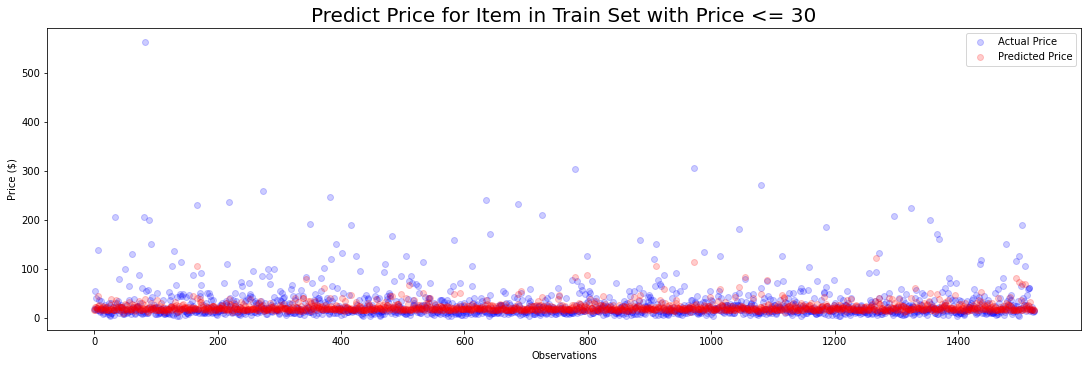

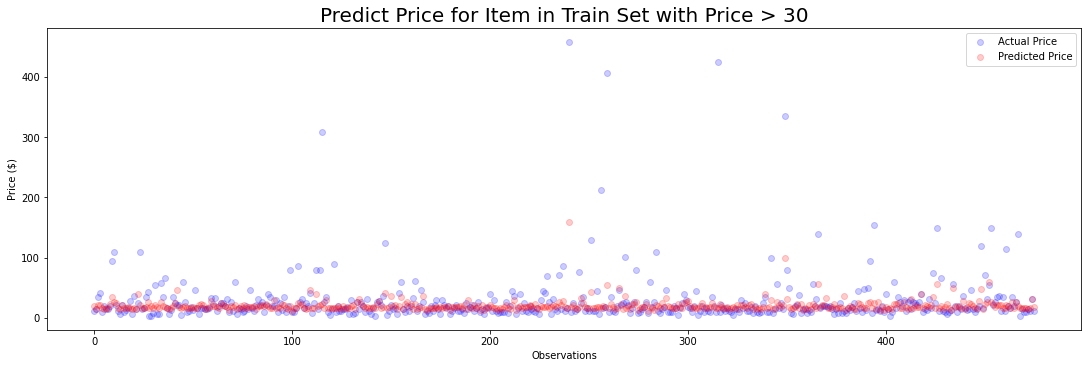

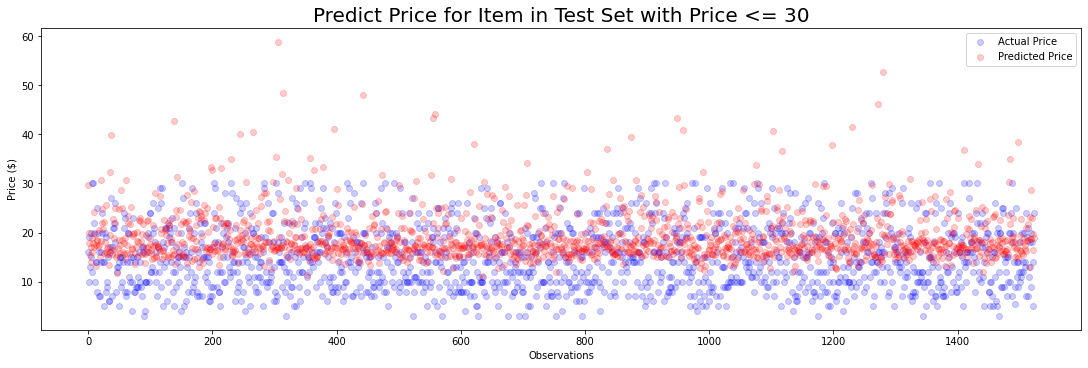

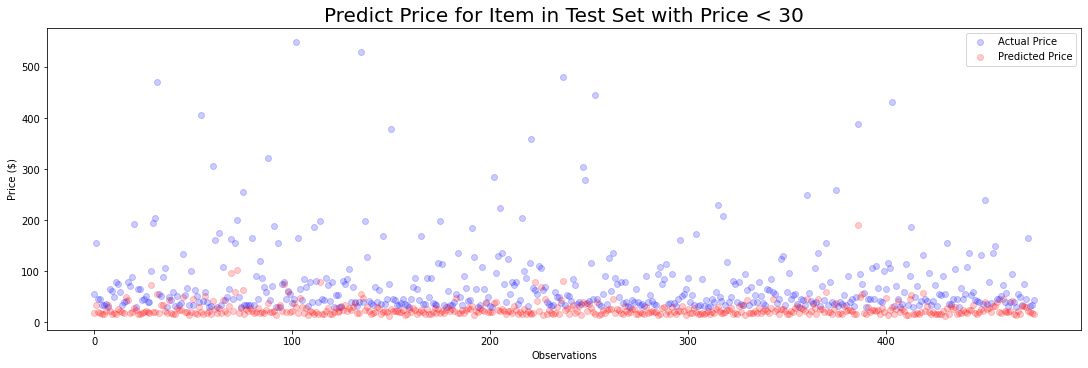

In [43]:
find_train_best_model(classifier, parameters, x_rfe_select_train, y_train, 
                      x_rfe_select_test, y_test, data_name="Feature from select k best model", price_split=30)